In [22]:
from scipy.integrate import solve_bvp
import numpy as np

from drone_utils_2 import *

from matplotlib import pyplot as plt

In [23]:
t_init = 0
t_final = 1
t_range = np.linspace(t_init, t_final, 30)

inerx = 1
inery = 1
inerz = 1
L = 1
lam = 1
g = 1
m = 1

# Penalizes yaw
alpha = 1 
# Penalizes tilt (pitch and roll)   
beta  = 1 
# Penalizes x, y position
gamma = 0 
# Penalizes height (z)
delta = 10  

In [24]:
state_init = np.array([
    0., # rotational velocity
    0., # rotational velocity
    0., # rotational velocity
    0., # rotational position
    0., # rotational position
    0., # rotational position
    0., # translational velocity
    0., # translational velocity
    0., # translational velocity
    0., # position (x)
    0., # position (y)
    1.  # position (z)
])

## Ensure that state evolution equations make sense

In [25]:
n_eval = 10

In [26]:
constant_control = 2.4 * np.array([1, 1, 1, 1.2]) # One rotor going harder than the rest
t_range = np.linspace(0, 1, n_eval)
delta_t = t_range[1] - t_range[0]

position = np.empty((len(t_range), 3))
orientation = np.empty((len(t_range), 3))
state = state_init
for t_index, t in enumerate(t_range):
    state_dot_t = state_dot(state, constant_control, inerx, inery, inerz, L, lam, g, m)
    state += delta_t * state_dot_t

    position[t_index] = state[9:12]
    orientation[t_index] = state[3:6]

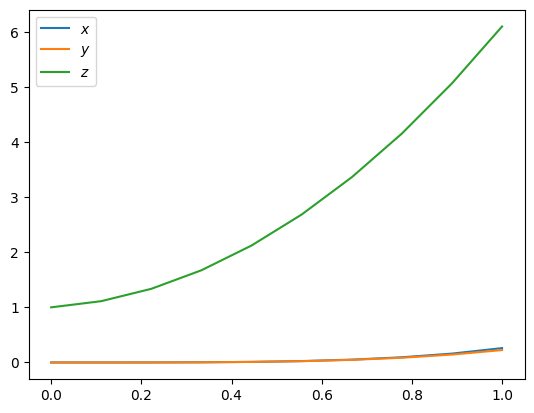

In [27]:
plt.plot(t_range, position[:], label=['$x$', '$y$', '$z$'])
plt.legend()
plt.show()

***
## Solve for optimal control

In [28]:
def ode(t, y):
    state = y[:12]
    costate = y[12:]

    control = optimal_control(costate, inerx, inery, inerz, L, lam, m)


    return np.hstack([
        state_dot(state, control, inerx, inery, inerz, L, lam, g, m),
        costate_dot(
            state, costate, inerx, inery, inerz, g,
            alpha=alpha, # Penalizes yaw
            beta=beta,  # Penalizes tilt (pitch and roll)
            gamma=gamma,  # Penalizes x, y position
            delta=delta # Penalizes height (z)
        )
    ])

def ode_vec(t, y):
    """ A vectorized version of `ode` to use within solve_bvp """
    dydt = np.empty_like(y)
    for i in range(t.size):
         dydt[:, i] = ode(t[i], y[:, i])
    return dydt

In [29]:
def bc_1(y_init, y_final): 
    return np.hstack([
        # We have initial vector for state
        y_init[:12] - state_init,
        # We know by Pontryagin that the final costate is 0
        y_final[12:]
    ])

def bc_2(y_init, y_final): 
    return np.hstack([
        # We have initial vector for state
        y_init[:12] - state_init,
        # We have final vector for state
        y_final[:12] - state_final
    ])

In [30]:
y_guess = np.zeros((24, len(t_range)))

sol = solve_bvp(
    ode_vec,
    bc_1,
    t_range,
    y_guess,
    max_nodes=50,
    verbose=2,
    tol=1e-1,
    bc_tol=1e-1
)

print(f'Status: {'Success' if sol.status == 0 else 'Fail'}')

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.67e+01       2.22e-15          10             10       
       2          6.70e+00       3.55e-15          20             19       
       3          1.12e+00       1.44e-15          39              2       
       4          1.02e+00       6.66e-16          41              2       
       5          9.76e-01       5.55e-17          43              2       
       6          9.67e-01       5.55e-17          45              2       
       7          9.65e-01       1.11e-16          47              2       
       8          9.72e-01       1.11e-16          49             (2)      
Number of nodes is exceeded after iteration 8. 
Maximum relative residual: 9.72e-01 
Maximum boundary residual: 1.11e-16
Status: Fail


In [31]:
t_range = sol.x
y_sol = sol.y

In [32]:
control = optimal_control(y_sol[12:], inerx, inery, inerz, L, lam, m)

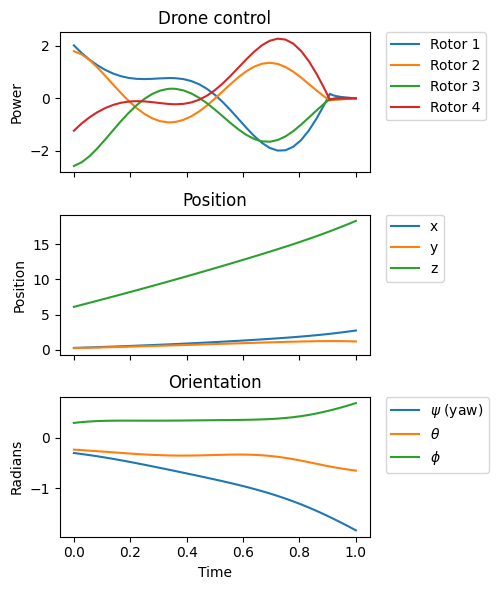

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(5, 6), sharex=True)

# Top: control signals
axes[0].plot(t_range, control[0], label='Rotor 1')
axes[0].plot(t_range, control[1], label='Rotor 2')
axes[0].plot(t_range, control[2], label='Rotor 3')
axes[0].plot(t_range, control[3], label='Rotor 4')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
axes[0].set_ylabel('Power')
axes[0].set_title('Drone control')

# Middle: position
axes[1].plot(t_range, y_sol[9], label='x')
axes[1].plot(t_range, y_sol[10], label='y')
axes[1].plot(t_range, y_sol[11], label='z')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
axes[1].set_title('Position')
axes[1].set_ylabel('Position')

# Bottom: orientation
axes[2].plot(t_range, sol.y[3], label=r'$\psi$ (yaw)')
axes[2].plot(t_range, sol.y[4], label=r'$\theta$')
axes[2].plot(t_range, sol.y[5], label=r'$\phi$')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
axes[2].set_title('Orientation')
axes[2].set_ylabel('Radians')
axes[2].set_xlabel('Time')

plt.tight_layout()
plt.subplots_adjust(right=0.75)  # make room on the right for legends
plt.show()